# **Capstone Project Report**

## **Comparing Neighborhood similarities between Toronto, ON and Boston, MA**

### By Anthony Oppong-Gyebi

### **1. Background and Problem Description**

The US, a cosmopolitan country sees many people around the globe travel in and out of it annually. Many of those immigrants rather settle in permanently to start families, businesses as well as on long vacations. Such immigrants preferably would want to situate in states which presents with similar amenities as their original homes, mainly for ease of adjustment to the new environment. For instance, persons travelling from coastal areas will wish to find homes and jobs in places where they can have access to the beaches as well as enjoy sea food, all year round. One major challenge immigrants face choosing neighborhoods which suitably fit their interests and like places where they had migrated from, considering unavailability of comprehensive comparative information for neighborhoods. The aim of this project, therefore, is to highlight the similarities in Toronto and Boston neighborhoods for Toronto, ON residents who intend to travel to Boston, MA and vice versa. This will be addressed segmenting and clustering the neighborhoods using machine learning techniques to compare the two cities.

### **2. Data Acquisition and Cleaning**

2.1 Source
The geojson file for Boston neighborhood will be obtained from the link http://bostonopendata-boston.opendata.arcgis.com/datasets/3525b0ee6e6b427f9aab5d0a1d0a1a28_0.geojson and web scraping will be used for the link https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M to glean the neighborhoods for Toronto.

2.2 Data Cleaning

The datasets contain extra information that must be gotten rid of to make the needed information clean and easy to work with. The Toronto dataset will be extracted from the borough and neighborhoods in the Canada dataset link above into a new dataframe while the Boston data geojson file will be used to obtain the boroughs and neighborhoods for Boston into another dataframe.

2.3 Feature selection

The distinct categories of venue locations in the neighborhoods of the two cities will be used to construct the features of the product. The coordinates of each neighborhood, that’s the latitude and longitudes shall be extracted from the datasets and used to obtain the diverse venues in the neighborhoods to bring to bear the similarities. Foursquare API will be used to generate the locations/ amenities within the specified vicinities followed by one-hot encoding to obtain the required features from the distinct categories. A mean of the total number of venues per neighborhood will be determined as representative of the fraction of distinct categories for the neighborhood. K Means clustering will be used to segment the neighborhoods to determine the key similarities between the two cities, Toronto and Boston.


### Import libraries

In [1]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
from bs4 import BeautifulSoup

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

import json # library to handle JSON files

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# import k-means from clustering stage
from sklearn.cluster import KMeans

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library

print('Libraries imported.')

Libraries imported.


### Getting credentials for FourSquare API

In [2]:
CLIENT_ID = 'E4UWB31YHAQOBUNJUUWZAELHIWLT0DMBCZ4SURPBFSR0NJQ2' # your Foursquare ID
CLIENT_SECRET = '0PXVLFHLBCDR42EZWNMQHOI0BIPTBTSGVJQSCZGHHCKX2RNI' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: E4UWB31YHAQOBUNJUUWZAELHIWLT0DMBCZ4SURPBFSR0NJQ2
CLIENT_SECRET:0PXVLFHLBCDR42EZWNMQHOI0BIPTBTSGVJQSCZGHHCKX2RNI


**Getting table from website for Toronto data**

In [3]:
wikipedia_page = 'List_of_postal_codes_of_Canada:_M'

In [4]:
wikipedia_url = 'https://en.wikipedia.org/wiki/{}'.format(wikipedia_page)
page = requests.get(wikipedia_url)

In [5]:
soup = BeautifulSoup(page.text, 'html.parser')

**Getting table data from the table**

In [6]:
table = soup.table

Postcode = []
Borough = []
Neighborhood = []

for rank, file in enumerate (table.find_all('td')):
    if rank%3 == 0:
        Postcode.append(file.text.rstrip())
    
    elif rank%3 == 1:
        Borough.append(file.text.rstrip())
    
    elif rank%3 == 2:
        Neighborhood.append(file.text.rstrip())

**Create and empty DataFrame with columns Postcode, Borough, Neighborhood**

In [7]:
df=pd.DataFrame(columns = ['Postal Code', 'Borough', 'Neighborhood'])
df

,Postal Code,Borough,Neighborhood


**Filling the new dataframe with the created list**

In [8]:
Zipcode= list(set(Postcode))

for a in Zipcode:
    post = a
    hood = ""
    for rank, file in enumerate(Postcode):
        if file == a:
            borough = Borough[rank]
            hood += Neighborhood[rank] + ', '
        
    hood = hood[:-2]
    df = df.append({'Postal Code': post,
                    'Borough': borough,
                    'Neighborhood':hood}, ignore_index = True)
df.head()
df.shape

(180, 3)

**Dropping unassigned Boroughs**

In [9]:
df.drop(index = df.index[df['Borough'] == 'Not assigned'], inplace = True)
df.reset_index (drop = True, inplace = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M3M,North York,Downsview Central
1,M2H,North York,Hillcrest Village
2,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter"
3,M4H,East York,Thorncliffe Park
4,M6E,York,Caledonia-Fairbanks


In [10]:
for rank,file in enumerate(df['Neighborhood']):
    if file == 'Not assigned':
        df.loc[rank, 'Neighborhood'] = df.loc[rank, 'Borough']
        
df.head()

,Postal Code,Borough,Neighborhood
0,M3M,North York,Downsview Central
1,M2H,North York,Hillcrest Village
2,M1T,Scarborough,"Clarks Corners, Sullivan, Tam O'Shanter"
3,M4H,East York,Thorncliffe Park
4,M6E,York,Caledonia-Fairbanks


In [11]:
rows, columns = df.shape

In [12]:
print ("New dataframe has "+str(rows)+" rows")

New dataframe has 103 rows


## **Linking geographical coordinates with neighborhoods**

In [13]:
#import geospatial coordinates
coords = r"C:\Users\aayte\OneDrive - University of North Texas Health Science Center\OneDrive\PROJECT\Study\Reads\Programming\Data Science\Anthony_Capstone\Anthony_Capstone_Codes\Geospatial_Coordinates.csv"
geo_coord = pd.read_csv (coords)
geo_coord.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


**Sort dataframe to match geospatial coordinates**

In [14]:
df.sort_values(by=['Postal Code'], ascending=True, inplace = True)
df.reset_index(drop = True, inplace = True)
df.head()

,Postal Code,Borough,Neighborhood
0,M1B,Scarborough,"Rouge, Malvern"
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


**Merge dataframe (df) with geospatial coordinates (geo_coord)**

In [15]:
df = df.join(geo_coord[['Latitude','Longitude']])
df.shape

(103, 5)

## **Segmenting and Clustering Neighborhoods in Toronto**

In [16]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

In [17]:
# First create a boolean list containing all the rows with Borough name ending with Toronto
indx = []
for i in range(df['Borough'].size):
    indx.append(df['Borough'][i].endswith('Toronto'))

# Use that list to create the new dataframe
Toronto_data = df[indx].reset_index(drop=True)
Toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,East Toronto,The Beaches,43.676357,-79.293031
1,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,East Toronto,Studio District,43.659526,-79.340923
4,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790


In [18]:
for index, row in Toronto_data.iterrows():
    Toronto_data.loc[index, "Borough"] = "Toronto"

In [19]:
Toronto_data.head()

,Postal Code,Borough,Neighborhood,Latitude,Longitude
0,M4E,Toronto,The Beaches,43.676357,-79.293031
1,M4K,Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
2,M4L,Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
3,M4M,Toronto,Studio District,43.659526,-79.340923
4,M4N,Toronto,Lawrence Park,43.728020,-79.388790


In [20]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="T_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Manhattan are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Manhattan are 43.653963, -79.387207.


In [21]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(Toronto_data['Latitude'],Toronto_data['Longitude'],Toronto_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

**Importing and cleaning data for Boston Neighborhoods**

In [22]:
Boston_json = r"C:\Users\aayte\OneDrive - University of North Texas Health Science Center\OneDrive\PROJECT\Study\Reads\Programming\Data Science\Anthony_Capstone\Anthony_Capstone_Codes\Capstone_Final\boston-neighborhoods.json"

In [23]:
with open (Boston_json) as json_data:
    boston_data = json.load (json_data)
neighborhood_data = boston_data['features']

In [24]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

neighborhoods.head()

for data in neighborhood_data:
    borough = neighborhood_name = data['properties']['Name'] 
    neighborhood_name = data['properties']['Name']
    
    neighborhood_latlon = data['geometry']['coordinates'][0][0]
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': 'Boston',
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)
    
    
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Boston,Roslindale,"[-71.12574734036883, 42.2723385402892]","[-71.12592656722312, 42.27200445346726]"
1,Boston,Jamaica Plain,42.3261,-71.105
2,Boston,Mission Hill,42.3358,-71.0904
3,Boston,Longwood Medical Area,42.3367,-71.0981
4,Boston,Bay Village,42.3488,-71.0666


In [25]:
neighborhoods.drop(neighborhoods.index[[0,7,12,13,15,21,25]], inplace = True)

In [26]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
1,Boston,Jamaica Plain,42.3261,-71.105
2,Boston,Mission Hill,42.3358,-71.0904
3,Boston,Longwood Medical Area,42.3367,-71.0981
4,Boston,Bay Village,42.3488,-71.0666
5,Boston,Leather District,42.3498,-71.0584


In [27]:
address = 'Boston, MA'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of {} are {}, {}.'.format('Boston', latitude, longitude))

The geograpical coordinate of Boston are 42.3602534, -71.0582912.


In [28]:
# create map of Manhattan using latitude and longitude values
map_neighborhoods = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_neighborhoods)  
    
map_neighborhoods

In [29]:
Comb_data = neighborhoods.append(Toronto_data.iloc[:,1:], ignore_index=True)

Comb_data.head()

,Borough,Neighborhood,Latitude,Longitude
0,Boston,Jamaica Plain,42.3261,-71.105
1,Boston,Mission Hill,42.3358,-71.0904
2,Boston,Longwood Medical Area,42.3367,-71.0981
3,Boston,Bay Village,42.3488,-71.0666
4,Boston,Leather District,42.3498,-71.0584


In [30]:
print('The combined data set has {} rows and should have {} rows'. format(Comb_data.shape[0], (Toronto_data.shape[0] + neighborhoods.shape[0])))

The combined data set has 57 rows and should have 57 rows


### **Using the Foursquare API to get venues around these neighborhoods**

In [31]:
def getNearbyVenues(names, borough, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, bor, lat, lng in zip(names, borough, latitudes, longitudes):
        print(name, bor)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            bor,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                  'Borough',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [32]:
LIMIT = 200
All_venues = getNearbyVenues(names=Comb_data['Neighborhood'],
                                  borough=Comb_data['Borough'],
                                   latitudes=Comb_data['Latitude'],
                                   longitudes=Comb_data['Longitude'])

Jamaica Plain Boston
Mission Hill Boston
Longwood Medical Area Boston
Bay Village Boston
Leather District Boston
Chinatown Boston
Roxbury Boston
South End Boston
Back Bay Boston
East Boston Boston
Beacon Hill Boston
Fenway Boston
Brighton Boston
West Roxbury Boston
Hyde Park Boston
Mattapan Boston
South Boston Waterfront Boston
South Boston Boston
Allston Boston
The Beaches Toronto
The Danforth West, Riverdale Toronto
The Beaches West, India Bazaar Toronto
Studio District Toronto
Lawrence Park Toronto
Davisville North Toronto
North Toronto West Toronto
Davisville Toronto
Moore Park, Summerhill East Toronto
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West Toronto
Rosedale Toronto
Cabbagetown, St. James Town Toronto
Church and Wellesley Toronto
Harbourfront, Regent Park Toronto
Ryerson, Garden District Toronto
St. James Town Toronto
Berczy Park Toronto
Central Bay Street Toronto
Adelaide, King, Richmond Toronto
Harbourfront East, Toronto Islands, Union Station Toronto
De

In [33]:
print(All_venues.shape)
All_venues.head()

(2407, 8)


,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Jamaica Plain,Boston,42.326093,-71.104992,The Frogmore,42.322489,-71.108238,Southern / Soul Food Restaurant
1,Jamaica Plain,Boston,42.326093,-71.104992,Yeli's Coffee Shop,42.322820,-71.101835,Caribbean Restaurant
2,Jamaica Plain,Boston,42.326093,-71.104992,Dunkin',42.323070,-71.103819,Donut Shop
3,Jamaica Plain,Boston,42.326093,-71.104992,Old Havana,42.322587,-71.106714,Cuban Restaurant
4,Jamaica Plain,Boston,42.326093,-71.104992,T-Mobile,42.323389,-71.103479,Mobile Phone Shop


In [34]:
print('There are {} uniques categories.'.format(len(All_venues['Venue Category'].unique())))

There are 272 uniques categories.


**Utilize one hot encoding to create features for the clustering**

In [35]:
# one hot encoding
All_onehot = pd.get_dummies(All_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
All_onehot[['Neighborhood', 'Borough']] = All_venues[['Neighborhood', 'Borough']]

# move neighborhood column to the first column
fixed_columns = [All_onehot.columns[-1]] + list(All_onehot.columns[:-1])
All_onehot = All_onehot[fixed_columns]

All_onehot.head()

,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,Boston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Boston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Boston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Boston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Boston,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
All_grouped = All_onehot.groupby(['Neighborhood', 'Borough']).mean().reset_index()
All_grouped

,Neighborhood,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",Toronto,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.010000,0.000000,0.000000,0.000000,0.000000,0.010000,0.000000,0.000000,0.000000
1,Allston,Boston,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Back Bay,Boston,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.026316,0.000000,0.000000
3,Bay Village,Boston,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.012987,0.000000,0.000000,0.012987,0.000000,0.000000,0.012987,0.000000,0.000000
4,Beacon Hill,Boston,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,Berczy Park,Toronto,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.017857,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Brighton,Boston,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,"Brockton, Exhibition Place, Parkdale Village",Toronto,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.047619
8,Business Reply Mail Processing Centre 969 Eastern,Toronto,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.052632
9,"CN Tower, Bathurst Quay, Island airport, Harbo...",Toronto,0.00,0.000000,0.000000,0.066667,0.066667,0.066667,0.133333,0.2,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


**Group one hot encoded dataframe by Neighborhood**

In [37]:
combined_count = All_onehot[['Neighborhood', 'Borough', 'Airport']].groupby(['Neighborhood',  'Borough']).count().reset_index()
combined_count.rename({'Airport':'Number of Venues'}, axis = 1, inplace = True)
combined_count.head()

,Neighborhood,Borough,Number of Venues
0,"Adelaide, King, Richmond",Toronto,100
1,Allston,Boston,22
2,Back Bay,Boston,38
3,Bay Village,Boston,77
4,Beacon Hill,Boston,42


In [38]:
meannum = combined_count.groupby('Borough').mean()
stdnum = combined_count.groupby('Borough').std().reset_index()
meannum.rename({'Number of Venues':'Mean Number of Venues'}, axis = 1, inplace = True)
meannum

,Mean Number of Venues
Borough,
Boston,37.052632
Toronto,44.815789


**Plot the mean number of venues**

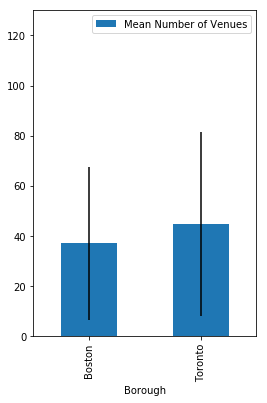

In [39]:
meannum.plot(kind = 'bar', figsize=(4, 6), yerr = stdnum.iloc[:,1].values)
plt.ylim(0, 130)
plt.legend()
plt.show()

**Group one hot encoded dataframe by Neighborhood**

In [40]:
All_grouped = All_onehot.groupby(['Neighborhood', 'Borough']).mean().reset_index()
All_grouped.head()

,Neighborhood,Borough,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,...,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Volleyball Court,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",Toronto,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.010000,0.0,0.0,0.000000,0.0,0.01,0.000000,0.0,0.0
1,Allston,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0
2,Back Bay,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.026316,0.0,0.0
3,Bay Village,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.012987,0.0,0.0,0.012987,0.0,0.00,0.012987,0.0,0.0
4,Beacon Hill,Boston,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0


In [41]:
All_grouped.shape

(57, 273)

**Determine the first number of most common venues for each of the big cities**

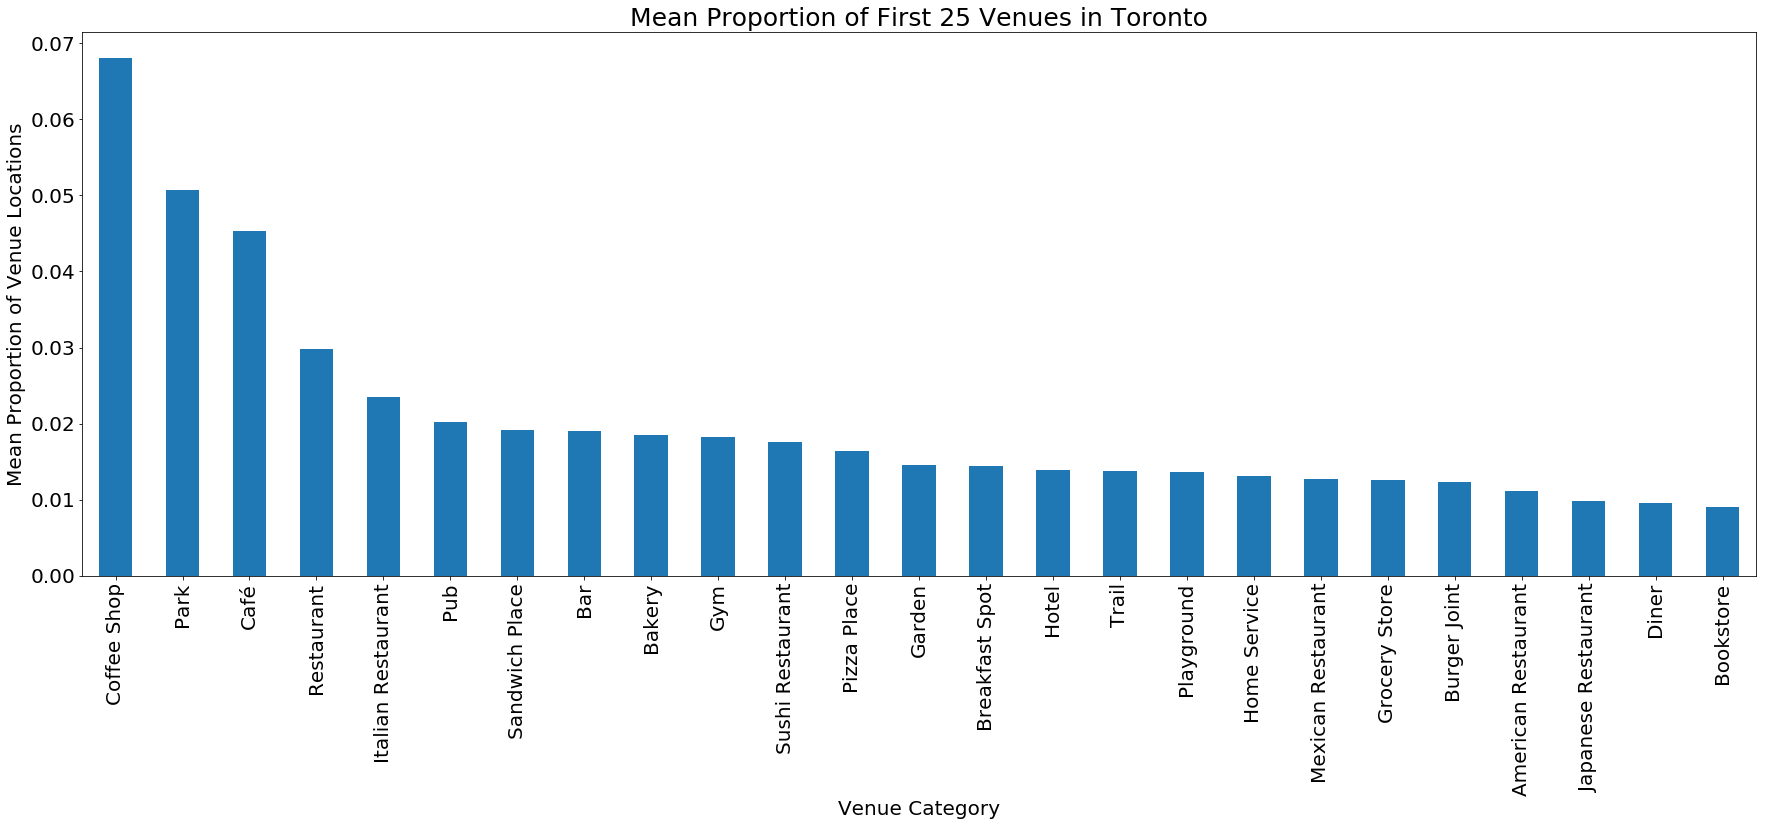

In [42]:
numcomb = 25
combined_Toronto_common = All_grouped.loc[All_grouped['Borough']=='Toronto'].mean(axis=0)
comb_Toronto = combined_Toronto_common.sort_values(ascending = False)[0:numcomb]

comb_Toronto.plot(kind = 'bar', figsize=(30,10), fontsize = 20)
plt.xlabel('Venue Category', fontsize = 20)
plt.ylabel('Mean Proportion of Venue Locations', fontsize = 20)
plt.title('Mean Proportion of First 25 Venues in Toronto', fontsize = 25)
plt.show()

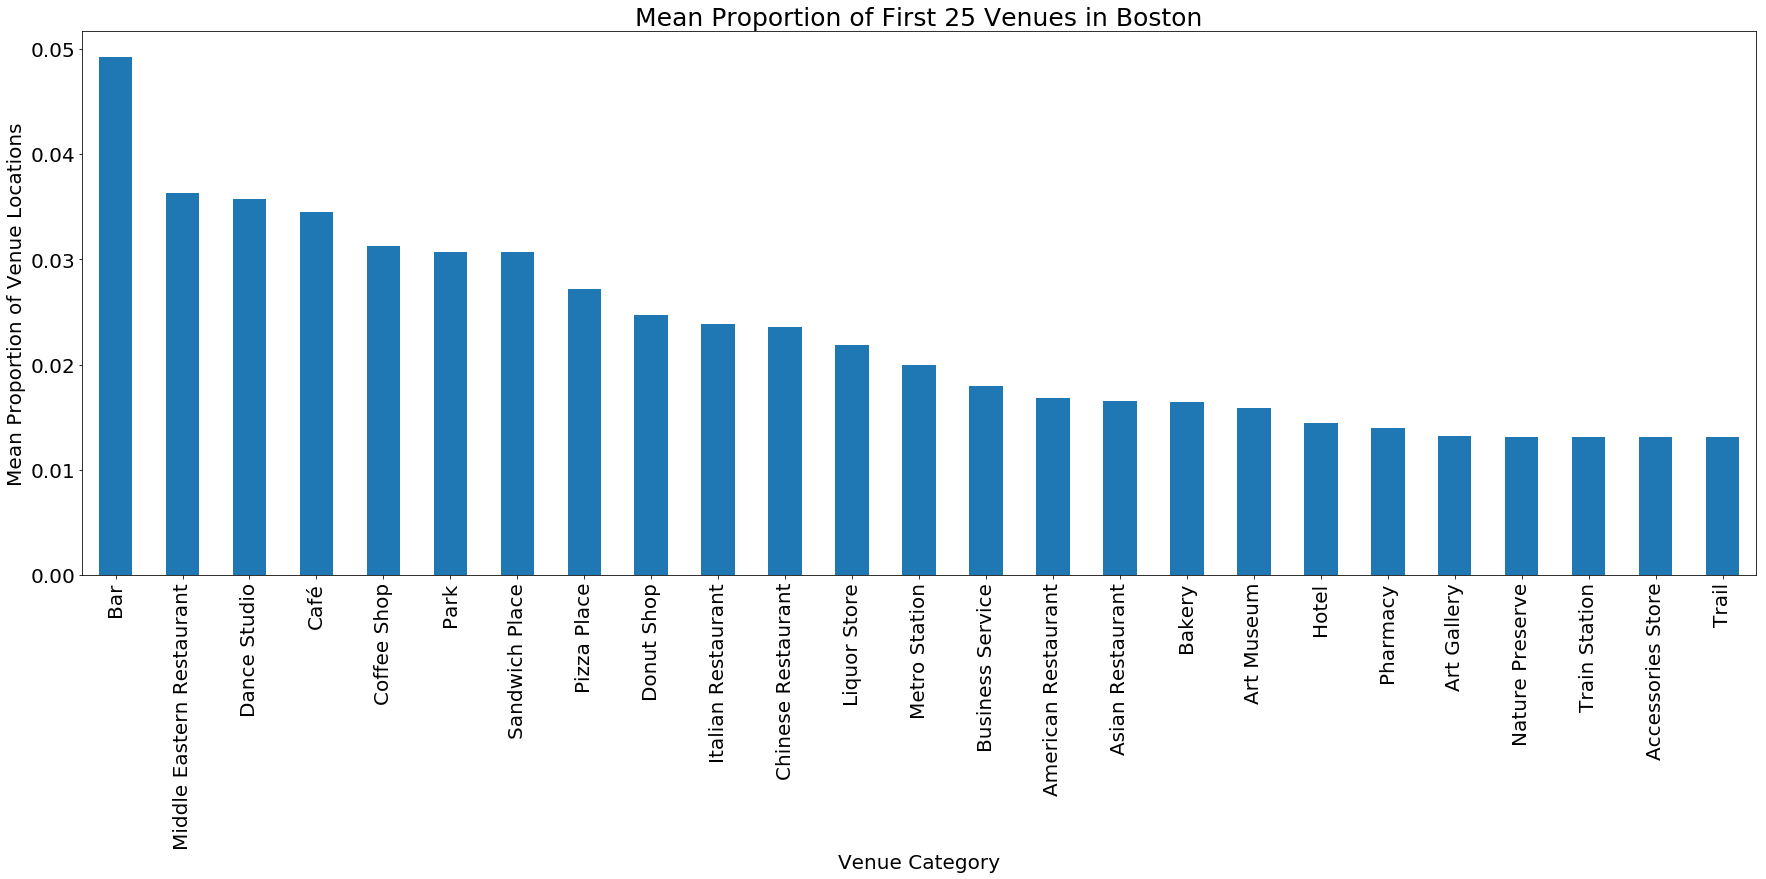

In [43]:
combined_Boston_common = All_grouped.loc[All_grouped['Borough']=='Boston'].mean(axis=0)
comb_Boston = combined_Boston_common.sort_values(ascending = False)[0:numcomb]

comb_Boston.plot(kind = 'bar', figsize=(30,10), fontsize = 20)
plt.xlabel('Venue Category', fontsize = 20)
plt.ylabel('Mean Proportion of Venue Locations', fontsize = 20)
plt.title('Mean Proportion of First 25 Venues in Boston', fontsize = 25)
plt.show()

**Use this function to return the most common venues for each Neighborhood**

In [44]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[2:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [45]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood', 'Borough']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Combined_venues_sorted = pd.DataFrame(columns=columns)
Combined_venues_sorted[['Neighborhood', 'Borough']] = All_grouped[['Neighborhood', 'Borough']]

for ind in np.arange(All_grouped.shape[0]):
    Combined_venues_sorted.iloc[ind, 2:] = return_most_common_venues(All_grouped.iloc[ind, :], num_top_venues)

Combined_venues_sorted.head()

,Neighborhood,Borough,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Toronto,Coffee Shop,Café,American Restaurant,Thai Restaurant,Steakhouse,Sushi Restaurant,Bakery,Burger Joint,Restaurant,Hotel
1,Allston,Boston,Pharmacy,Pizza Place,Bar,Metro Station,Speakeasy,Residential Building (Apartment / Condo),Chinese Restaurant,Coffee Shop,Playground,Plaza
2,Back Bay,Boston,Café,Pizza Place,Italian Restaurant,Bakery,Clothing Store,Gift Shop,American Restaurant,French Restaurant,Bar,Kids Store
3,Bay Village,Boston,Theater,Hotel,Steakhouse,Italian Restaurant,Sandwich Place,Seafood Restaurant,Spa,Gym / Fitness Center,Sushi Restaurant,Bakery
4,Beacon Hill,Boston,Hotel Bar,Italian Restaurant,Gourmet Shop,Gift Shop,American Restaurant,Grocery Store,Kids Store,Baseball Field,Sushi Restaurant,Clothing Store


### **Clustering the Neighborhoods**

In [46]:
# set number of clusters
Combined_grouped_clustering = All_grouped.drop(['Neighborhood', 'Borough'], 1)
Inertia = []
allclusters = np.arange(2, 10)

for kclusters in allclusters:
    
    # run k-means clustering
    kmeans = KMeans(n_clusters=kclusters, random_state=4).fit(Combined_grouped_clustering)
    # check cluster labels generated for each row in the dataframe
    
    #inert = metrics.silhouette_score(Combined_grouped_clustering, kmeans.labels_, metric='euclidean')
    #inert = metrics.calinski_harabaz_score(Combined_grouped_clustering, kmeans.labels_)
    Inertia.append(kmeans.inertia_)

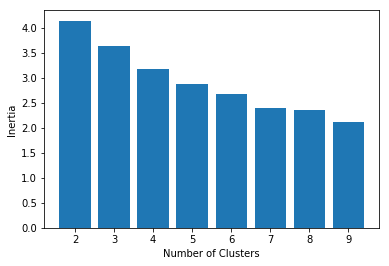

In [47]:
plt.bar(allclusters, Inertia)
plt.xticks(allclusters)
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

### Run k-means clustering for chosen number of clusters

In [48]:
kmeans = KMeans(n_clusters=9, random_state=4).fit(Combined_grouped_clustering)

**Merge Original Data and Cluster Labels**

In [49]:
# add clustering labels
Combined_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)
Combined_venues_sorted.drop(['Borough'], 1, inplace = True)

Combined_merged = Comb_data

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Combined_merged = Combined_merged.join(Combined_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

In [50]:
Combined_merged.sort_values('Cluster Labels', inplace = True) # check the last columns!
Combined_merged = Combined_merged.reset_index(drop=True)
Combined_merged.head()

,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Boston,Jamaica Plain,42.3261,-71.105,0,Sandwich Place,Supermarket,Deli / Bodega,Latin American Restaurant,Caribbean Restaurant,Cuban Restaurant,Donut Shop,Southern / Soul Food Restaurant,Mobile Phone Shop,Metro Station
1,Toronto,"High Park, The Junction South",43.6616,-79.4648,0,Café,Bar,Mexican Restaurant,Furniture / Home Store,Fried Chicken Joint,Bakery,Diner,Music Venue,Italian Restaurant,Thai Restaurant
2,Toronto,"Dovercourt Village, Dufferin",43.669,-79.4423,0,Bakery,Supermarket,Pharmacy,Fast Food Restaurant,Café,Bar,Music Venue,Discount Store,Middle Eastern Restaurant,Liquor Store
3,Toronto,"CN Tower, Bathurst Quay, Island airport, Harbo...",43.6289,-79.3944,0,Airport Service,Airport Lounge,Airport Terminal,Plane,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Boat or Ferry
4,Toronto,North Toronto West,43.7154,-79.4057,0,Clothing Store,Coffee Shop,Sporting Goods Shop,Gift Shop,Fast Food Restaurant,Metro Station,Mexican Restaurant,Diner,Dessert Shop,Park


### Examine Clusters

**Determine the Number of Neighborhoods in each cluster grouped by the name of the city**

In [51]:
ClusterSum = Combined_merged[['Neighborhood', 'Borough', 'Cluster Labels']].groupby(['Cluster Labels', 'Borough']).count().reset_index()

ClusterSum

,Cluster Labels,Borough,Neighborhood
0,0,Boston,12
1,0,Toronto,7
2,1,Toronto,1
3,2,Toronto,1
4,3,Boston,2
5,4,Toronto,1
6,5,Boston,1
7,6,Boston,4
8,6,Toronto,26
9,7,Toronto,1


**Create a figure for Number of Neighborhoods Grouped by Cluster Type and City**

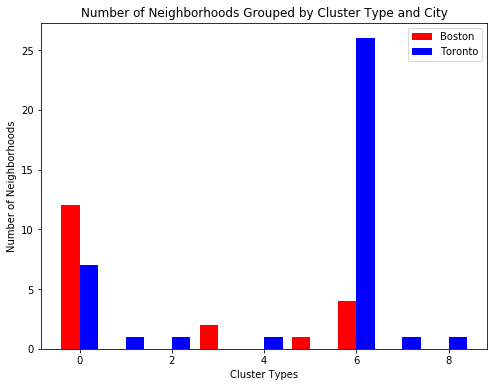

In [52]:
fig, ax = plt.subplots(figsize = (8, 6))
bar_width = 0.4

x_boston = ClusterSum[ClusterSum['Borough']=='Boston']['Cluster Labels'].values
y_boston =  ClusterSum[ClusterSum['Borough']=='Boston']['Neighborhood'].values

x_toronto = ClusterSum[ClusterSum['Borough']=='Toronto']['Cluster Labels'].values
y_toronto =  ClusterSum[ClusterSum['Borough']=='Toronto']['Neighborhood'].values

ax.bar(x_boston-(bar_width/2), y_boston, width = bar_width, color = 'r')
ax.bar(x_toronto+(bar_width/2), y_toronto, width = bar_width, color = 'b')

ax.set_xlabel('Cluster Types', fontsize = 10)
ax.set_ylabel('Number of Neighborhoods', fontsize = 10)
ax.set_title('Number of Neighborhoods Grouped by Cluster Type and City', fontsize = 12)
ax.legend(['Boston', 'Toronto'])

plt.show()

In [53]:
ClusterCommon = pd.get_dummies(Combined_merged.iloc[:, [5]], prefix="", prefix_sep="")

ClusterCommon[['Cluster Labels', 'Borough']] = Combined_merged[['Cluster Labels', 'Borough']]

ClusterComGrp = ClusterCommon.groupby(['Cluster Labels']).mean().reset_index()
ClusterComGrp

,Cluster Labels,Accessories Store,Airport Service,American Restaurant,Art Gallery,Art Museum,Athletics & Sports,Bakery,Bar,Café,...,Hotel Bar,Jewelry Store,Light Rail Station,Nature Preserve,Park,Pharmacy,Playground,Sandwich Place,Swim School,Theater
0,0,0.0,0.052632,0.052632,0.052632,0.052632,0.052632,0.052632,0.000000,0.052632,...,0.052632,0.0,0.052632,0.052632,0.052632,0.000000,0.0,0.105263,0.0,0.052632
1,1,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.000000,0.0,0.000000
2,2,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
3,3,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
4,4,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,1.0,0.000000
5,5,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000
6,6,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.033333,0.166667,...,0.000000,0.0,0.000000,0.000000,0.033333,0.066667,0.0,0.033333,0.0,0.000000
7,7,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0,0.000000
8,8,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000


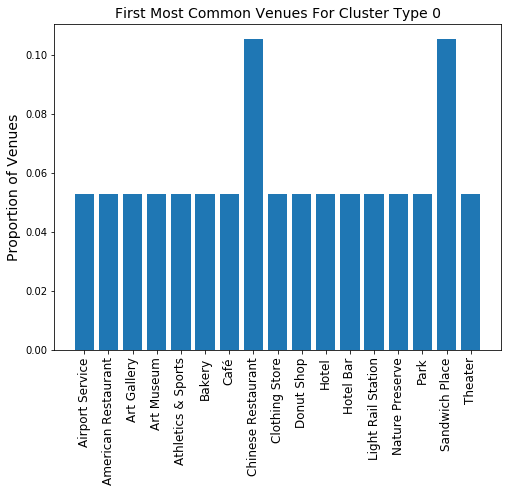

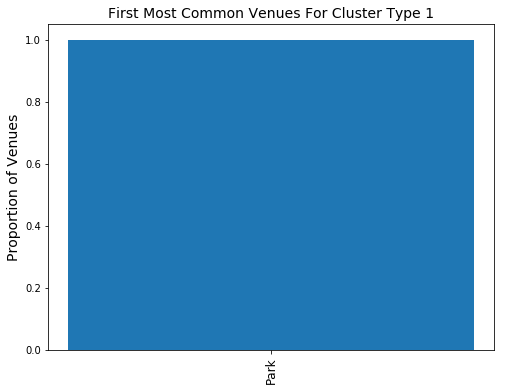

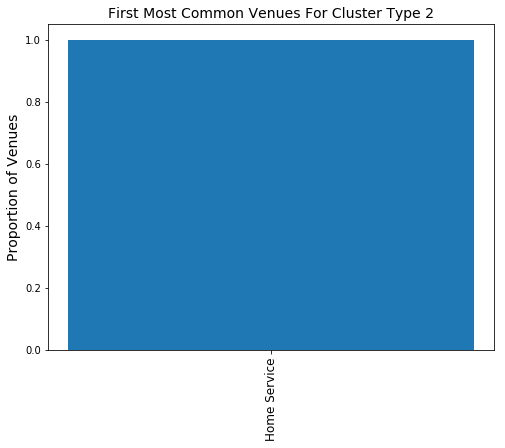

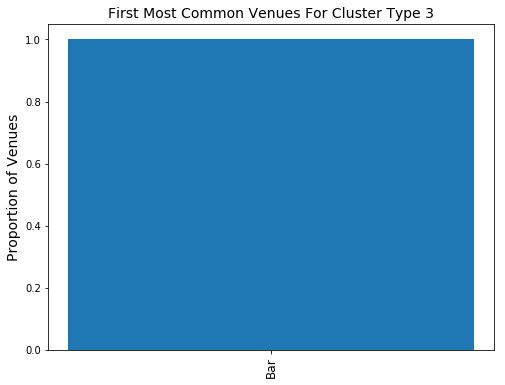

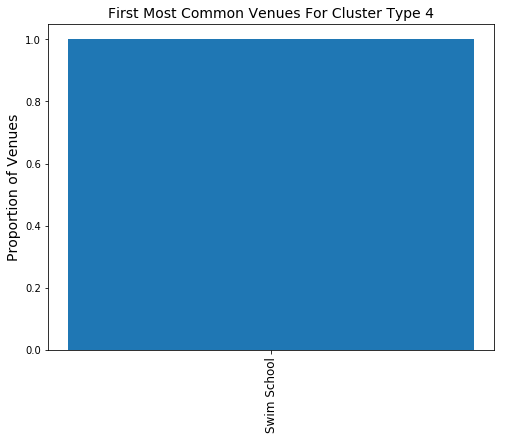

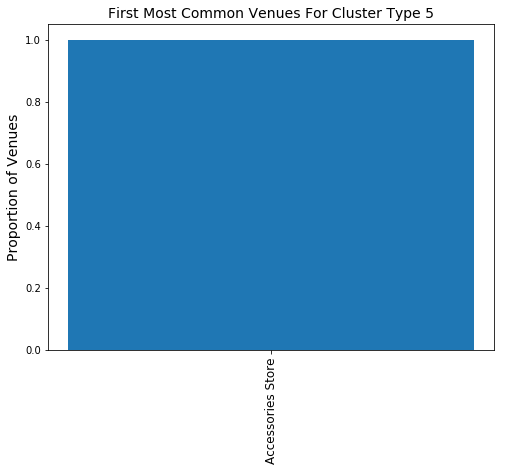

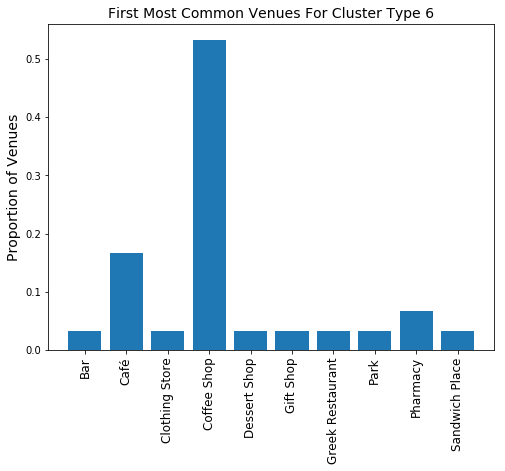

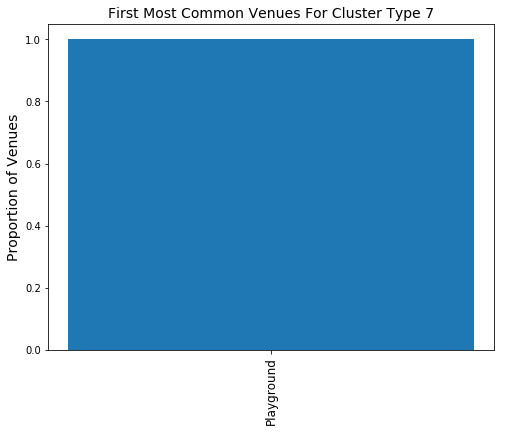

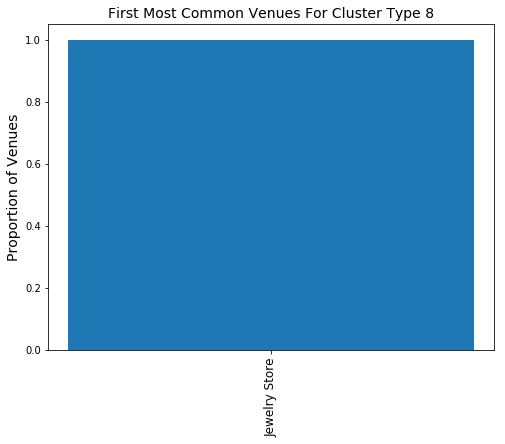

In [54]:
for i in np.arange(9):

    k = ClusterComGrp.loc[ClusterComGrp['Cluster Labels']==i, ClusterComGrp.columns[1]:ClusterComGrp.columns[-1]]
    kk = k.iloc[:, np.nonzero(k.values)[1]]
    kk.sort_values(i, axis = 1, ascending = False)

    fig, ax = plt.subplots(figsize = (8,6))
    ax.bar(np.arange(kk.shape[1]), kk.iloc[0, :].values, width = 0.8)
    ax.set_xticks(np.arange(kk.shape[1]))
    ax.set_xticklabels(kk.columns, fontdict = {'fontsize': 12}, rotation = 90)
    ax.set_ylabel('Proportion of Venues', fontsize = 14)
    ax.set_title('First Most Common Venues For Cluster Type {}'.format(i), fontsize = 14)
    plt.show()

In [55]:
ClusterNeigh = Combined_merged[['Neighborhood', 'Borough', 'Cluster Labels']]

for i in np.arange(9):
    ClusterNeigh_T = ClusterNeigh[ClusterNeigh['Cluster Labels']==i].sort_values(by='Borough').reset_index(drop=True)
    print('Cluster Type {}'.format(i))
    print(ClusterNeigh_T)
    '/n'

Cluster Type 0
                                         Neighborhood  Borough  Cluster Labels
0                                       Jamaica Plain   Boston               0
1                                         Beacon Hill   Boston               0
2                                        Mission Hill   Boston               0
3                                           South End   Boston               0
4                               Longwood Medical Area   Boston               0
5                                    Leather District   Boston               0
6                                           Chinatown   Boston               0
7                                         East Boston   Boston               0
8                                           Hyde Park   Boston               0
9                                        South Boston   Boston               0
10                            South Boston Waterfront   Boston               0
11                                   